In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=400 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-8],]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((t_len,2,55,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,5))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (1000, 2)
Dimension - airfoil coordinates:  (2000, 50)
Dimension - coord with flaps:  (2000, 5)
Dimension - total coordinates:  (2000, 55)
Dimension - x_time:  (1000, 1)
Dimension - x_coordinates:  (1000, 2, 55, 1)
Dimension - y:  (1000, 1)


In [21]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [22]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [23]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [24]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,55,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='same', activation='relu',
                                     name='convLayer',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(input_coord)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [25]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 400)   2000        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 400)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 10800)        0           ['max_pooling2d[0][0]']          
                                                                                              

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20230102\\Case15(l2)"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20230102unsteady_AeroCNN1_Case15(l2)_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
3/3 [==============================] - ETA: 0s - loss: 0.2185 - rmse: 0.4673 
Epoch 1: val_loss improved from inf to 0.17250, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 15s 367ms/step - loss: 0.2185 - rmse: 0.4673 - val_loss: 0.1725 - val_rmse: 0.4152 - lr: 1.0000e-04
Epoch 2/10000
3/3 [==============================] - ETA: 0s - loss: 0.1945 - rmse: 0.4409
Epoch 2: val_loss improved from 0.17250 to 0.15608, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 131ms/step - loss: 0.1945 - rmse: 0.4409 - val_loss: 0.1561 - val_rmse: 0.3949 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1932 - rmse: 0.4394
Epoch 3: val_loss improved from 0.15608 to 0.13524,

Epoch 25/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0648 - rmse: 0.2543
Epoch 25: val_loss did not improve from 0.04782
3/3 [==============================] - 0s 22ms/step - loss: 0.0588 - rmse: 0.2422 - val_loss: 0.0483 - val_rmse: 0.2194 - lr: 1.0000e-04
Epoch 26/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0809 - rmse: 0.2841
Epoch 26: val_loss did not improve from 0.04782
3/3 [==============================] - 0s 22ms/step - loss: 0.0639 - rmse: 0.2524 - val_loss: 0.0484 - val_rmse: 0.2196 - lr: 1.0000e-04
Epoch 27/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0639 - rmse: 0.2525
Epoch 27: val_loss did not improve from 0.04782
3/3 [==============================] - 0s 21ms/step - loss: 0.0626 - rmse: 0.2499 - val_loss: 0.0485 - val_rmse: 0.2198 - lr: 1.0000e-04
Epoch 28/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0661 - rmse: 0.2568
Epoch 28: val_loss did not improve from 0.04782
3/3 [========================

Epoch 53/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0632 - rmse: 0.2510
Epoch 53: val_loss did not improve from 0.04771
3/3 [==============================] - 0s 23ms/step - loss: 0.0620 - rmse: 0.2486 - val_loss: 0.0479 - val_rmse: 0.2186 - lr: 1.0000e-04
Epoch 54/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0592 - rmse: 0.2430
Epoch 54: val_loss did not improve from 0.04771
3/3 [==============================] - 0s 23ms/step - loss: 0.0611 - rmse: 0.2469 - val_loss: 0.0477 - val_rmse: 0.2181 - lr: 1.0000e-04
Epoch 55/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0575 - rmse: 0.2395
Epoch 55: val_loss did not improve from 0.04771
3/3 [==============================] - 0s 22ms/step - loss: 0.0606 - rmse: 0.2459 - val_loss: 0.0479 - val_rmse: 0.2186 - lr: 1.0000e-04
Epoch 56/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0711 - rmse: 0.2663
Epoch 56: val_loss did not improve from 0.04771
3/3 [========================

3/3 [==============================] - 0s 23ms/step - loss: 0.0607 - rmse: 0.2460 - val_loss: 0.0474 - val_rmse: 0.2173 - lr: 1.0000e-04
Epoch 81/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0564 - rmse: 0.2371
Epoch 81: val_loss did not improve from 0.04727
3/3 [==============================] - 0s 25ms/step - loss: 0.0619 - rmse: 0.2484 - val_loss: 0.0478 - val_rmse: 0.2184 - lr: 1.0000e-04
Epoch 82/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0541 - rmse: 0.2323
Epoch 82: val_loss did not improve from 0.04727
3/3 [==============================] - 0s 24ms/step - loss: 0.0561 - rmse: 0.2365 - val_loss: 0.0476 - val_rmse: 0.2179 - lr: 1.0000e-04
Epoch 83/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0683 - rmse: 0.2611
Epoch 83: val_loss did not improve from 0.04727
3/3 [==============================] - 0s 23ms/step - loss: 0.0651 - rmse: 0.2548 - val_loss: 0.0474 - val_rmse: 0.2175 - lr: 1.0000e-04
Epoch 84/10000
1/3 [=========>..

1/3 [=========>....................] - ETA: 0s - loss: 0.0627 - rmse: 0.2502
Epoch 105: val_loss improved from 0.04601 to 0.04538, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 96ms/step - loss: 0.0564 - rmse: 0.2373 - val_loss: 0.0454 - val_rmse: 0.2127 - lr: 1.0000e-04
Epoch 106/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0665 - rmse: 0.2577
Epoch 106: val_loss did not improve from 0.04538
3/3 [==============================] - 0s 28ms/step - loss: 0.0609 - rmse: 0.2466 - val_loss: 0.0456 - val_rmse: 0.2131 - lr: 1.0000e-04
Epoch 107/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0536 - rmse: 0.2311
Epoch 107: val_loss did not improve from 0.04538
3/3 [==============================] - 0s 27ms/step - loss: 0.0557 - rmse: 0.2356 - val_loss: 0.0460 - val_rmse: 0.2142 - lr: 1.0000e-04
Epoch 108/10000
1/3 [====

1/3 [=========>....................] - ETA: 0s - loss: 0.0496 - rmse: 0.2224
Epoch 128: val_loss did not improve from 0.04134
3/3 [==============================] - 0s 28ms/step - loss: 0.0469 - rmse: 0.2163 - val_loss: 0.0414 - val_rmse: 0.2032 - lr: 1.0000e-04
Epoch 129/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0452 - rmse: 0.2123
Epoch 129: val_loss improved from 0.04134 to 0.04087, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 77ms/step - loss: 0.0485 - rmse: 0.2199 - val_loss: 0.0409 - val_rmse: 0.2018 - lr: 1.0000e-04
Epoch 130/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0529 - rmse: 0.2297
Epoch 130: val_loss improved from 0.04087 to 0.04011, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [===

3/3 [==============================] - 0s 99ms/step - loss: 0.0386 - rmse: 0.1960 - val_loss: 0.0313 - val_rmse: 0.1765 - lr: 1.0000e-04
Epoch 151/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0360 - rmse: 0.1894
Epoch 151: val_loss improved from 0.03131 to 0.02940, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 85ms/step - loss: 0.0349 - rmse: 0.1863 - val_loss: 0.0294 - val_rmse: 0.1710 - lr: 1.0000e-04
Epoch 152/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0389 - rmse: 0.1969
Epoch 152: val_loss improved from 0.02940 to 0.02926, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 76ms/step - loss: 0.0360 - rmse: 0.1893 - val_loss: 0.0293 - val_rmse: 0.1706 - lr: 1.0000e-

Epoch 171/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0135 - rmse: 0.1157
Epoch 171: val_loss improved from 0.01251 to 0.01044, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 113ms/step - loss: 0.0128 - rmse: 0.1127 - val_loss: 0.0104 - val_rmse: 0.1015 - lr: 1.0000e-04
Epoch 172/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0113 - rmse: 0.1057
Epoch 172: val_loss did not improve from 0.01044
3/3 [==============================] - 0s 35ms/step - loss: 0.0130 - rmse: 0.1133 - val_loss: 0.0113 - val_rmse: 0.1058 - lr: 1.0000e-04
Epoch 173/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0115 - rmse: 0.1067
Epoch 173: val_loss improved from 0.01044 to 0.00870, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_check

1/3 [=========>....................] - ETA: 0s - loss: 0.0060 - rmse: 0.0765
Epoch 193: val_loss did not improve from 0.00177
3/3 [==============================] - 0s 22ms/step - loss: 0.0042 - rmse: 0.0637 - val_loss: 0.0026 - val_rmse: 0.0490 - lr: 1.0000e-04
Epoch 194/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0041 - rmse: 0.0626
Epoch 194: val_loss improved from 0.00177 to 0.00134, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 95ms/step - loss: 0.0037 - rmse: 0.0596 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 1.0000e-04
Epoch 195/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0024 - rmse: 0.0472
Epoch 195: val_loss did not improve from 0.00134
3/3 [==============================] - 0s 21ms/step - loss: 0.0029 - rmse: 0.0520 - val_loss: 0.0030 - val_rmse: 0.0530 - lr: 1.0000e-04
Epoch 196/10000
1/3 [====

Epoch 217/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0297
Epoch 217: val_loss did not improve from 0.00078
3/3 [==============================] - 0s 38ms/step - loss: 0.0015 - rmse: 0.0370 - val_loss: 8.2009e-04 - val_rmse: 0.0259 - lr: 1.0000e-04
Epoch 218/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.6672e-04 - rmse: 0.0286
Epoch 218: val_loss did not improve from 0.00078
3/3 [==============================] - 0s 37ms/step - loss: 0.0013 - rmse: 0.0346 - val_loss: 7.9460e-04 - val_rmse: 0.0254 - lr: 1.0000e-04
Epoch 219/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 219: val_loss improved from 0.00078 to 0.00078, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 95ms/step - loss: 0.0013 - rmse: 0.0342 - val_loss: 7.7907e-04 - val_rmse: 0.0251 - lr: 1.00

3/3 [==============================] - 0s 74ms/step - loss: 9.8657e-04 - rmse: 0.0290 - val_loss: 6.4732e-04 - val_rmse: 0.0224 - lr: 1.0000e-04
Epoch 241/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.6298e-04 - rmse: 0.0267
Epoch 241: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 22ms/step - loss: 0.0012 - rmse: 0.0322 - val_loss: 6.5131e-04 - val_rmse: 0.0224 - lr: 1.0000e-04
Epoch 242/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0301
Epoch 242: val_loss did not improve from 0.00065
3/3 [==============================] - 0s 22ms/step - loss: 0.0011 - rmse: 0.0311 - val_loss: 6.5750e-04 - val_rmse: 0.0226 - lr: 1.0000e-04
Epoch 243/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 243: val_loss improved from 0.00065 to 0.00063, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_che

Epoch 265/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0011 - rmse: 0.0309
Epoch 265: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 23ms/step - loss: 0.0010 - rmse: 0.0296 - val_loss: 5.8273e-04 - val_rmse: 0.0209 - lr: 1.0000e-04
Epoch 266/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3181e-04 - rmse: 0.0280
Epoch 266: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 24ms/step - loss: 0.0011 - rmse: 0.0302 - val_loss: 5.9972e-04 - val_rmse: 0.0213 - lr: 1.0000e-04
Epoch 267/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0293
Epoch 267: val_loss did not improve from 0.00056
3/3 [==============================] - 0s 23ms/step - loss: 0.0010 - rmse: 0.0294 - val_loss: 5.9985e-04 - val_rmse: 0.0213 - lr: 1.0000e-04
Epoch 268/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0010 - rmse: 0.0299
Epoch 268: val_loss did not improve from 0.00056
3/3 [

Epoch 290/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0332
Epoch 290: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 25ms/step - loss: 0.0011 - rmse: 0.0307 - val_loss: 5.2822e-04 - val_rmse: 0.0196 - lr: 1.0000e-04
Epoch 291/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.2632e-04 - rmse: 0.0219
Epoch 291: val_loss improved from 0.00050 to 0.00050, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 107ms/step - loss: 6.4007e-04 - rmse: 0.0222 - val_loss: 4.9928e-04 - val_rmse: 0.0188 - lr: 1.0000e-04
Epoch 292/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.4609e-04 - rmse: 0.0265
Epoch 292: val_loss did not improve from 0.00050
3/3 [==============================] - 0s 25ms/step - loss: 9.0198e-04 - rmse: 0.0275 - val_loss: 5.0076e-04 - val_rmse: 0.01

Epoch 314/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7022e-04 - rmse: 0.0206
Epoch 314: val_loss did not improve from 0.00043
3/3 [==============================] - 0s 36ms/step - loss: 7.5253e-04 - rmse: 0.0247 - val_loss: 4.5265e-04 - val_rmse: 0.0176 - lr: 1.0000e-04
Epoch 315/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.8994e-04 - rmse: 0.0211
Epoch 315: val_loss improved from 0.00043 to 0.00042, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 109ms/step - loss: 5.3804e-04 - rmse: 0.0198 - val_loss: 4.1686e-04 - val_rmse: 0.0165 - lr: 1.0000e-04
Epoch 316/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.6220e-04 - rmse: 0.0249
Epoch 316: val_loss did not improve from 0.00042
3/3 [==============================] - 0s 33ms/step - loss: 7.6662e-04 - rmse: 0.0249 - val_loss: 4.3530e-04 - val_rm

3/3 [==============================] - 0s 100ms/step - loss: 6.2946e-04 - rmse: 0.0220 - val_loss: 3.8328e-04 - val_rmse: 0.0155 - lr: 1.0000e-04
Epoch 340/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7229e-04 - rmse: 0.0181
Epoch 340: val_loss improved from 0.00038 to 0.00038, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 88ms/step - loss: 5.3002e-04 - rmse: 0.0197 - val_loss: 3.7868e-04 - val_rmse: 0.0153 - lr: 1.0000e-04
Epoch 341/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.4201e-04 - rmse: 0.0200
Epoch 341: val_loss improved from 0.00038 to 0.00037, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 94ms/step - loss: 5.9580e-04 - rmse: 0.0213 - val_loss: 3.6800e-04 

3/3 [==============================] - 0s 79ms/step - loss: 5.1014e-04 - rmse: 0.0192 - val_loss: 3.4385e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 364/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4457e-04 - rmse: 0.0174
Epoch 364: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 24ms/step - loss: 4.9060e-04 - rmse: 0.0187 - val_loss: 3.6906e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 365/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.0863e-04 - rmse: 0.0216
Epoch 365: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 24ms/step - loss: 4.8776e-04 - rmse: 0.0186 - val_loss: 4.2364e-04 - val_rmse: 0.0168 - lr: 1.0000e-04
Epoch 366/10000
1/3 [=========>....................] - ETA: 0s - loss: 6.5094e-04 - rmse: 0.0226
Epoch 366: val_loss did not improve from 0.00034
3/3 [==============================] - 0s 24ms/step - loss: 4.9946e-04 - rmse: 0.0189 - val_loss: 3.5617e-04 - val_rmse: 0.0146

1/3 [=========>....................] - ETA: 0s - loss: 6.1581e-04 - rmse: 0.0218
Epoch 390: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 26ms/step - loss: 4.6197e-04 - rmse: 0.0179 - val_loss: 3.3572e-04 - val_rmse: 0.0139 - lr: 1.0000e-04
Epoch 391/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.8003e-04 - rmse: 0.0184
Epoch 391: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 25ms/step - loss: 4.6274e-04 - rmse: 0.0179 - val_loss: 3.6050e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 392/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.9470e-04 - rmse: 0.0159
Epoch 392: val_loss did not improve from 0.00030
3/3 [==============================] - 0s 25ms/step - loss: 4.6338e-04 - rmse: 0.0180 - val_loss: 2.9940e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 393/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3844e-04 - rmse: 0.0140
Epoch 393: val_loss did not improve from 0.000

Epoch 414/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.5918e-04 - rmse: 0.0179
Epoch 414: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 37ms/step - loss: 3.4306e-04 - rmse: 0.0142 - val_loss: 2.7583e-04 - val_rmse: 0.0116 - lr: 1.0000e-04
Epoch 415/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5260e-04 - rmse: 0.0146
Epoch 415: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 34ms/step - loss: 3.3696e-04 - rmse: 0.0140 - val_loss: 2.8603e-04 - val_rmse: 0.0121 - lr: 1.0000e-04
Epoch 416/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8810e-04 - rmse: 0.0157
Epoch 416: val_loss did not improve from 0.00026
3/3 [==============================] - 0s 35ms/step - loss: 3.4497e-04 - rmse: 0.0143 - val_loss: 2.9581e-04 - val_rmse: 0.0125 - lr: 1.0000e-04
Epoch 417/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9220e-04 - rmse: 0.0123
Epoch 417: val_loss did not im

Epoch 441/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.3205e-04 - rmse: 0.0139
Epoch 441: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 22ms/step - loss: 3.4024e-04 - rmse: 0.0142 - val_loss: 2.7049e-04 - val_rmse: 0.0115 - lr: 1.0000e-04
Epoch 442/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1048e-04 - rmse: 0.0085
Epoch 442: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 3.0449e-04 - rmse: 0.0129 - val_loss: 2.9481e-04 - val_rmse: 0.0125 - lr: 1.0000e-04
Epoch 443/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5571e-04 - rmse: 0.0108
Epoch 443: val_loss did not improve from 0.00023
3/3 [==============================] - 0s 21ms/step - loss: 2.4569e-04 - rmse: 0.0103 - val_loss: 2.5745e-04 - val_rmse: 0.0109 - lr: 1.0000e-04
Epoch 444/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1185e-04 - rmse: 0.0132
Epoch 444: val_loss did not im

3/3 [==============================] - 0s 74ms/step - loss: 2.5861e-04 - rmse: 0.0110 - val_loss: 2.0993e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 468/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7384e-04 - rmse: 0.0117
Epoch 468: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 22ms/step - loss: 2.4752e-04 - rmse: 0.0105 - val_loss: 2.1617e-04 - val_rmse: 0.0089 - lr: 1.0000e-04
Epoch 469/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5730e-04 - rmse: 0.0109
Epoch 469: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 23ms/step - loss: 2.2542e-04 - rmse: 0.0094 - val_loss: 2.1486e-04 - val_rmse: 0.0088 - lr: 1.0000e-04
Epoch 470/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0580e-04 - rmse: 0.0130
Epoch 470: val_loss did not improve from 0.00021
3/3 [==============================] - 0s 23ms/step - loss: 2.5377e-04 - rmse: 0.0108 - val_loss: 2.1095e-04 - val_rmse: 0.0086

Epoch 495/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1467e-04 - rmse: 0.0088
Epoch 495: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 24ms/step - loss: 2.1723e-04 - rmse: 0.0090 - val_loss: 2.2684e-04 - val_rmse: 0.0095 - lr: 1.0000e-04
Epoch 496/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4001e-04 - rmse: 0.0102
Epoch 496: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 23ms/step - loss: 2.3659e-04 - rmse: 0.0100 - val_loss: 2.1576e-04 - val_rmse: 0.0089 - lr: 1.0000e-04
Epoch 497/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4139e-04 - rmse: 0.0102
Epoch 497: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 24ms/step - loss: 2.3484e-04 - rmse: 0.0099 - val_loss: 2.1507e-04 - val_rmse: 0.0089 - lr: 1.0000e-04
Epoch 498/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2875e-04 - rmse: 0.0096
Epoch 498: val_loss did not im

1/3 [=========>....................] - ETA: 0s - loss: 1.9789e-04 - rmse: 0.0079
Epoch 522: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 25ms/step - loss: 1.9202e-04 - rmse: 0.0075 - val_loss: 2.0792e-04 - val_rmse: 0.0085 - lr: 1.0000e-04
Epoch 523/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2067e-04 - rmse: 0.0092
Epoch 523: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 24ms/step - loss: 2.0277e-04 - rmse: 0.0082 - val_loss: 1.8207e-04 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 524/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8719e-04 - rmse: 0.0072
Epoch 524: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 24ms/step - loss: 1.9857e-04 - rmse: 0.0080 - val_loss: 1.9168e-04 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 525/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.0631e-04 - rmse: 0.0084
Epoch 525: val_loss did not improve from 0.000

1/3 [=========>....................] - ETA: 0s - loss: 2.0257e-04 - rmse: 0.0083
Epoch 550: val_loss improved from 0.00018 to 0.00018, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 84ms/step - loss: 2.2045e-04 - rmse: 0.0093 - val_loss: 1.7952e-04 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 551/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7315e-04 - rmse: 0.0062
Epoch 551: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 27ms/step - loss: 1.9756e-04 - rmse: 0.0080 - val_loss: 2.2097e-04 - val_rmse: 0.0093 - lr: 1.0000e-04
Epoch 552/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9293e-04 - rmse: 0.0077
Epoch 552: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 26ms/step - loss: 2.1914e-04 - rmse: 0.0092 - val_loss: 2.1971e-04 - val_rmse: 0.0093 - lr: 

Epoch 575/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8380e-04 - rmse: 0.0071
Epoch 575: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 25ms/step - loss: 2.3028e-04 - rmse: 0.0099 - val_loss: 1.8957e-04 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 576/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7481e-04 - rmse: 0.0065
Epoch 576: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 25ms/step - loss: 2.2327e-04 - rmse: 0.0095 - val_loss: 2.3875e-04 - val_rmse: 0.0103 - lr: 1.0000e-04
Epoch 577/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2501e-04 - rmse: 0.0096
Epoch 577: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 27ms/step - loss: 2.5648e-04 - rmse: 0.0111 - val_loss: 3.5970e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 578/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1938e-04 - rmse: 0.0137
Epoch 578: val_loss did not im

1/3 [=========>....................] - ETA: 0s - loss: 1.9248e-04 - rmse: 0.0078
Epoch 603: val_loss improved from 0.00017 to 0.00017, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 71ms/step - loss: 2.0756e-04 - rmse: 0.0087 - val_loss: 1.6568e-04 - val_rmse: 0.0058 - lr: 1.0000e-04
Epoch 604/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7620e-04 - rmse: 0.0067
Epoch 604: val_loss improved from 0.00017 to 0.00016, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 73ms/step - loss: 1.9214e-04 - rmse: 0.0078 - val_loss: 1.6194e-04 - val_rmse: 0.0055 - lr: 1.0000e-04
Epoch 605/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6831e-04 - rmse: 0.0060
Epoch 605: val_loss did not i

Epoch 630/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7367e-04 - rmse: 0.0066
Epoch 630: val_loss improved from 0.00016 to 0.00016, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 90ms/step - loss: 1.7514e-04 - rmse: 0.0067 - val_loss: 1.5618e-04 - val_rmse: 0.0051 - lr: 1.0000e-04
Epoch 631/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5736e-04 - rmse: 0.0052
Epoch 631: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 25ms/step - loss: 1.5588e-04 - rmse: 0.0050 - val_loss: 1.6309e-04 - val_rmse: 0.0057 - lr: 1.0000e-04
Epoch 632/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6029e-04 - rmse: 0.0054
Epoch 632: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 26ms/step - loss: 1.6621e-04 - rmse: 0.0060 - val_loss: 1.6378e-04 - val_rms

Epoch 658/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9301e-04 - rmse: 0.0080
Epoch 658: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 26ms/step - loss: 1.8510e-04 - rmse: 0.0075 - val_loss: 1.8644e-04 - val_rmse: 0.0075 - lr: 1.0000e-04
Epoch 659/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7872e-04 - rmse: 0.0070
Epoch 659: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 25ms/step - loss: 1.8338e-04 - rmse: 0.0073 - val_loss: 1.5657e-04 - val_rmse: 0.0052 - lr: 1.0000e-04
Epoch 660/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7172e-04 - rmse: 0.0065
Epoch 660: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 25ms/step - loss: 1.5683e-04 - rmse: 0.0052 - val_loss: 1.5832e-04 - val_rmse: 0.0054 - lr: 1.0000e-04
Epoch 661/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6057e-04 - rmse: 0.0056
Epoch 661: val_loss improved f

1/3 [=========>....................] - ETA: 0s - loss: 1.7562e-04 - rmse: 0.0069
Epoch 685: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 26ms/step - loss: 2.0496e-04 - rmse: 0.0088 - val_loss: 1.5557e-04 - val_rmse: 0.0052 - lr: 1.0000e-04
Epoch 686/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4092e-04 - rmse: 0.0036
Epoch 686: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 26ms/step - loss: 1.6636e-04 - rmse: 0.0062 - val_loss: 1.5319e-04 - val_rmse: 0.0050 - lr: 1.0000e-04
Epoch 687/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5709e-04 - rmse: 0.0054
Epoch 687: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 25ms/step - loss: 1.6149e-04 - rmse: 0.0058 - val_loss: 1.6089e-04 - val_rmse: 0.0057 - lr: 1.0000e-04
Epoch 688/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5828e-04 - rmse: 0.0055
Epoch 688: val_loss did not improve from 0.000

1/3 [=========>....................] - ETA: 0s - loss: 2.0712e-04 - rmse: 0.0089
Epoch 713: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 25ms/step - loss: 2.2346e-04 - rmse: 0.0098 - val_loss: 1.6802e-04 - val_rmse: 0.0064 - lr: 1.0000e-04
Epoch 714/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6691e-04 - rmse: 0.0063
Epoch 714: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 26ms/step - loss: 1.7703e-04 - rmse: 0.0071 - val_loss: 1.5050e-04 - val_rmse: 0.0048 - lr: 1.0000e-04
Epoch 715/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4722e-04 - rmse: 0.0045
Epoch 715: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 25ms/step - loss: 1.6207e-04 - rmse: 0.0059 - val_loss: 1.6567e-04 - val_rmse: 0.0062 - lr: 1.0000e-04
Epoch 716/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8598e-04 - rmse: 0.0077
Epoch 716: val_loss did not improve from 0.000

Epoch 740/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5507e-04 - rmse: 0.0054
Epoch 740: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 25ms/step - loss: 1.5014e-04 - rmse: 0.0049 - val_loss: 1.4571e-04 - val_rmse: 0.0044 - lr: 1.0000e-04
Epoch 741/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4622e-04 - rmse: 0.0045
Epoch 741: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 26ms/step - loss: 1.4465e-04 - rmse: 0.0043 - val_loss: 1.5148e-04 - val_rmse: 0.0051 - lr: 1.0000e-04
Epoch 742/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7524e-04 - rmse: 0.0070
Epoch 742: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 26ms/step - loss: 1.5299e-04 - rmse: 0.0052 - val_loss: 1.6803e-04 - val_rmse: 0.0065 - lr: 1.0000e-04
Epoch 743/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6167e-04 - rmse: 0.0060
Epoch 743: val_loss did not im

1/3 [=========>....................] - ETA: 0s - loss: 1.7444e-04 - rmse: 0.0070
Epoch 768: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 25ms/step - loss: 1.7827e-04 - rmse: 0.0073 - val_loss: 1.5406e-04 - val_rmse: 0.0054 - lr: 1.0000e-04
Epoch 769/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5399e-04 - rmse: 0.0054
Epoch 769: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 26ms/step - loss: 1.7478e-04 - rmse: 0.0071 - val_loss: 2.8863e-04 - val_rmse: 0.0128 - lr: 1.0000e-04
Epoch 770/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.7038e-04 - rmse: 0.0121
Epoch 770: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 26ms/step - loss: 2.1295e-04 - rmse: 0.0094 - val_loss: 2.2153e-04 - val_rmse: 0.0098 - lr: 1.0000e-04
Epoch 771/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3223e-04 - rmse: 0.0104
Epoch 771: val_loss did not improve from 0.000

Epoch 796/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6105e-04 - rmse: 0.0061
Epoch 796: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 25ms/step - loss: 1.7159e-04 - rmse: 0.0069 - val_loss: 1.6830e-04 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 797/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6850e-04 - rmse: 0.0067
Epoch 797: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 25ms/step - loss: 1.6291e-04 - rmse: 0.0063 - val_loss: 1.8373e-04 - val_rmse: 0.0078 - lr: 1.0000e-04
Epoch 798/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8625e-04 - rmse: 0.0079
Epoch 798: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 26ms/step - loss: 1.7058e-04 - rmse: 0.0069 - val_loss: 1.5602e-04 - val_rmse: 0.0057 - lr: 1.0000e-04
Epoch 799/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5783e-04 - rmse: 0.0058
Epoch 799: val_loss improved f

1/3 [=========>....................] - ETA: 0s - loss: 1.4533e-04 - rmse: 0.0048
Epoch 823: val_loss did not improve from 0.00014

Epoch 823: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
3/3 [==============================] - 0s 25ms/step - loss: 1.5058e-04 - rmse: 0.0053 - val_loss: 1.6033e-04 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 824/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5193e-04 - rmse: 0.0054
Epoch 824: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 25ms/step - loss: 1.5158e-04 - rmse: 0.0054 - val_loss: 1.5631e-04 - val_rmse: 0.0058 - lr: 5.0000e-05
Epoch 825/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5103e-04 - rmse: 0.0053
Epoch 825: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 26ms/step - loss: 1.5051e-04 - rmse: 0.0053 - val_loss: 1.4379e-04 - val_rmse: 0.0046 - lr: 5.0000e-05
Epoch 826/10000
1/3 [=========>....................] - ETA: 0s -

Epoch 849/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3376e-04 - rmse: 0.0034
Epoch 849: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 27ms/step - loss: 1.3500e-04 - rmse: 0.0036 - val_loss: 1.3538e-04 - val_rmse: 0.0036 - lr: 5.0000e-05
Epoch 850/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3070e-04 - rmse: 0.0029
Epoch 850: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 26ms/step - loss: 1.3536e-04 - rmse: 0.0036 - val_loss: 1.3523e-04 - val_rmse: 0.0036 - lr: 5.0000e-05
Epoch 851/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3071e-04 - rmse: 0.0029
Epoch 851: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 25ms/step - loss: 1.3203e-04 - rmse: 0.0032 - val_loss: 1.3526e-04 - val_rmse: 0.0036 - lr: 5.0000e-05
Epoch 852/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3257e-04 - rmse: 0.0032
Epoch 852: val_loss did not im

1/3 [=========>....................] - ETA: 0s - loss: 1.3476e-04 - rmse: 0.0036
Epoch 876: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 25ms/step - loss: 1.3414e-04 - rmse: 0.0035 - val_loss: 1.3561e-04 - val_rmse: 0.0037 - lr: 5.0000e-05
Epoch 877/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3498e-04 - rmse: 0.0037
Epoch 877: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 26ms/step - loss: 1.3552e-04 - rmse: 0.0037 - val_loss: 1.3414e-04 - val_rmse: 0.0035 - lr: 5.0000e-05
Epoch 878/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3613e-04 - rmse: 0.0038
Epoch 878: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 26ms/step - loss: 1.3483e-04 - rmse: 0.0036 - val_loss: 1.3418e-04 - val_rmse: 0.0036 - lr: 5.0000e-05
Epoch 879/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3509e-04 - rmse: 0.0037
Epoch 879: val_loss did not improve from 0.000

1/3 [=========>....................] - ETA: 0s - loss: 1.3528e-04 - rmse: 0.0038
Epoch 903: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 25ms/step - loss: 1.3454e-04 - rmse: 0.0037 - val_loss: 1.3322e-04 - val_rmse: 0.0035 - lr: 5.0000e-05
Epoch 904/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3479e-04 - rmse: 0.0037
Epoch 904: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 25ms/step - loss: 1.3522e-04 - rmse: 0.0038 - val_loss: 1.3351e-04 - val_rmse: 0.0035 - lr: 5.0000e-05
Epoch 905/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2770e-04 - rmse: 0.0026
Epoch 905: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 26ms/step - loss: 1.3223e-04 - rmse: 0.0033 - val_loss: 1.3364e-04 - val_rmse: 0.0036 - lr: 5.0000e-05
Epoch 906/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4186e-04 - rmse: 0.0046
Epoch 906: val_loss did not improve from 0.000

Epoch 930/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3519e-04 - rmse: 0.0038
Epoch 930: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 26ms/step - loss: 1.3379e-04 - rmse: 0.0036 - val_loss: 1.3272e-04 - val_rmse: 0.0035 - lr: 5.0000e-05
Epoch 931/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3102e-04 - rmse: 0.0032
Epoch 931: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 25ms/step - loss: 1.3321e-04 - rmse: 0.0036 - val_loss: 1.3335e-04 - val_rmse: 0.0036 - lr: 5.0000e-05
Epoch 932/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3569e-04 - rmse: 0.0039
Epoch 932: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 25ms/step - loss: 1.3393e-04 - rmse: 0.0037 - val_loss: 1.3322e-04 - val_rmse: 0.0036 - lr: 5.0000e-05
Epoch 933/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3602e-04 - rmse: 0.0039
Epoch 933: val_loss did not im

Epoch 957/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3524e-04 - rmse: 0.0039
Epoch 957: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 27ms/step - loss: 1.3239e-04 - rmse: 0.0035 - val_loss: 1.3197e-04 - val_rmse: 0.0034 - lr: 2.5000e-05
Epoch 958/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2599e-04 - rmse: 0.0024
Epoch 958: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 26ms/step - loss: 1.3117e-04 - rmse: 0.0033 - val_loss: 1.3275e-04 - val_rmse: 0.0035 - lr: 2.5000e-05
Epoch 959/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2633e-04 - rmse: 0.0025
Epoch 959: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 25ms/step - loss: 1.2887e-04 - rmse: 0.0029 - val_loss: 1.3138e-04 - val_rmse: 0.0033 - lr: 2.5000e-05
Epoch 960/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3156e-04 - rmse: 0.0034
Epoch 960: val_loss did not im

Epoch 985/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3672e-04 - rmse: 0.0041
Epoch 985: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 26ms/step - loss: 1.3119e-04 - rmse: 0.0034 - val_loss: 1.3067e-04 - val_rmse: 0.0033 - lr: 2.5000e-05
Epoch 986/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2673e-04 - rmse: 0.0026
Epoch 986: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 79ms/step - loss: 1.3064e-04 - rmse: 0.0033 - val_loss: 1.3037e-04 - val_rmse: 0.0032 - lr: 2.5000e-05
Epoch 987/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2772e-04 - rmse: 0.0028
Epoch 987: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kerne

3/3 [==============================] - 0s 115ms/step - loss: 1.3207e-04 - rmse: 0.0035 - val_loss: 1.2979e-04 - val_rmse: 0.0032 - lr: 2.5000e-05
Epoch 1011/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.2965e-04 - rmse: 0.0032
Epoch 1011: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 25ms/step - loss: 1.2826e-04 - rmse: 0.0029 - val_loss: 1.3087e-04 - val_rmse: 0.0033 - lr: 2.5000e-05
Epoch 1012/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3070e-04 - rmse: 0.0033
Epoch 1012: val_loss did not improve from 0.00013
3/3 [==============================] - 0s 25ms/step - loss: 1.3155e-04 - rmse: 0.0034 - val_loss: 1.3001e-04 - val_rmse: 0.0032 - lr: 2.5000e-05
Epoch 1013/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3085e-04 - rmse: 0.0033
Epoch 1013: val_loss improved from 0.00013 to 0.00013, saving model to D:\TrainedModels\20230102\Case15(l2)20230102unsteady_AeroCNN1_Case15(l2)_val_0.2_test0.1_400kernels

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:01:49.172181


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230102_AeroCNN1_Case15(l2)_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

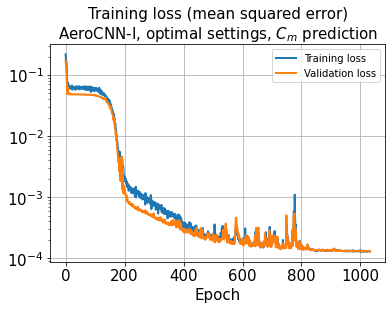

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

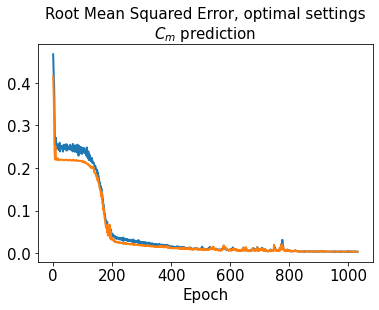

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

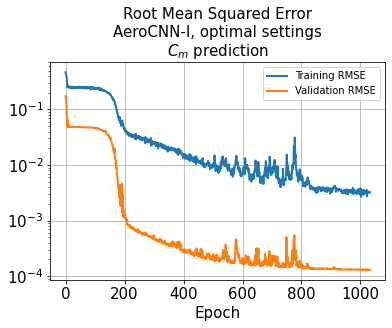

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

22/22 [==============================] - 0s 8ms/step - loss: 1.3490e-04 - rmse: 0.0035


In [37]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

7/7 [==============================] - 0s 10ms/step - loss: 1.3485e-04 - rmse: 0.0035


In [38]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

4/4 [==============================] - 0s 13ms/step - loss: 1.2932e-04 - rmse: 0.0026


In [39]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

4/4 [==============================] - 0s 3ms/step


In [40]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.00749728074379056
0.2420679972855395


In [46]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.00808912515675011
0.2954378079594559


In [47]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.005780201755597515
0.20374380556789123


In [48]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [49]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [50]:
model_directory = "D:\\TrainedModels\\20230102"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20230102unsteady_AeroCNN1_Case15(l2)_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [52]:
os.chdir(storage_dir)

In [53]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [56]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [57]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [58]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [59]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

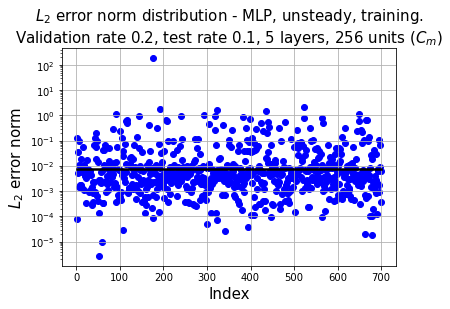

In [60]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

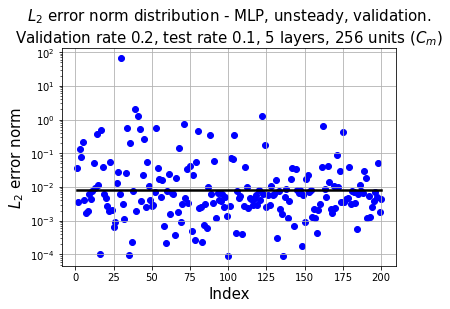

In [61]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

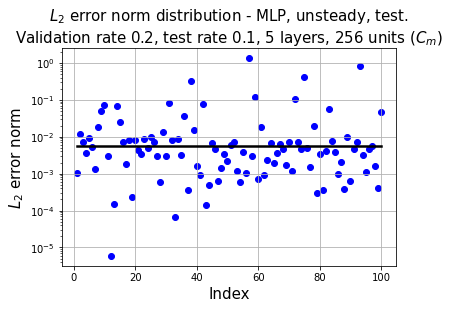

In [62]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [63]:
predicted = model.predict([x_time, x_coord])

32/32 [==============================] - 0s 4ms/step


In [64]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [65]:
max(predicted)

array([0.999818], dtype=float32)

In [66]:
print(l2_error(predicted, y))

0.007459639783263054


In [67]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [68]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [69]:
t

array([[0.   ],
       [0.001],
       [0.002],
       [0.003],
       [0.004],
       [0.005],
       [0.006],
       [0.007],
       [0.008],
       [0.009],
       [0.01 ],
       [0.011],
       [0.012],
       [0.013],
       [0.014],
       [0.015],
       [0.016],
       [0.017],
       [0.018],
       [0.019],
       [0.02 ],
       [0.021],
       [0.022],
       [0.023],
       [0.024],
       [0.025],
       [0.026],
       [0.027],
       [0.028],
       [0.029],
       [0.03 ],
       [0.031],
       [0.032],
       [0.033],
       [0.034],
       [0.035],
       [0.036],
       [0.037],
       [0.038],
       [0.039],
       [0.04 ],
       [0.041],
       [0.042],
       [0.043],
       [0.044],
       [0.045],
       [0.046],
       [0.047],
       [0.048],
       [0.049],
       [0.05 ],
       [0.051],
       [0.052],
       [0.053],
       [0.054],
       [0.055],
       [0.056],
       [0.057],
       [0.058],
       [0.059],
       [0.06 ],
       [0.061],
       [

In [70]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [71]:
x_time += 10

L2 error of Cm: 0.0075


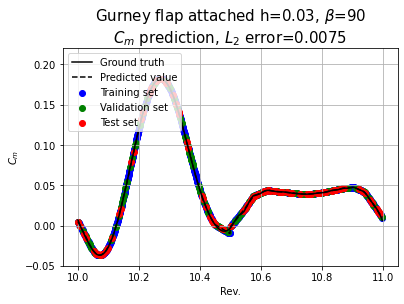

In [72]:
h = [0.03]
beta = [90]
for i in range(0,1):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [126]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0075


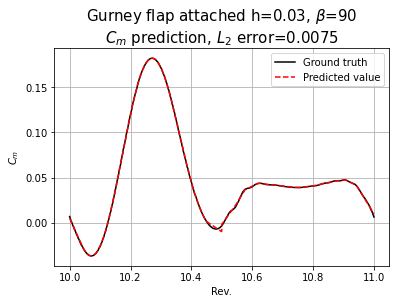

In [127]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0075


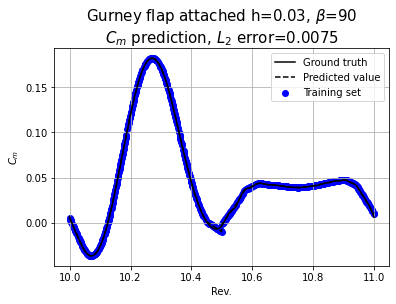

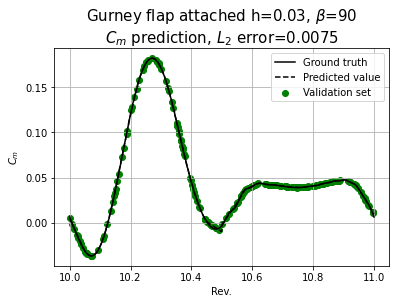

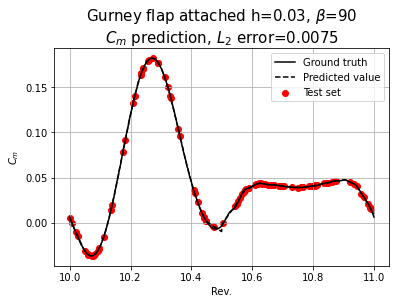

In [75]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    # Cm graph plot
    ## Training dataset
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

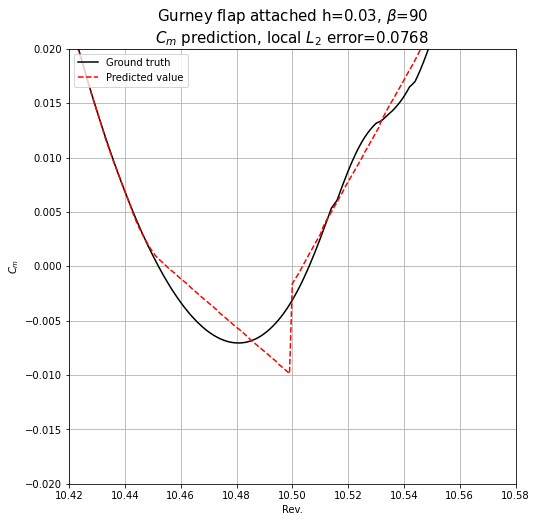

In [123]:
plt.figure(figsize=(8,8))
plt.plot(t, cm, 'k-', label='Ground truth')
plt.plot(t, denormalize(predicted), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
plt.xlim([10.42, 10.58])
plt.ylim([-0.02, 0.02])
plt.grid()
plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

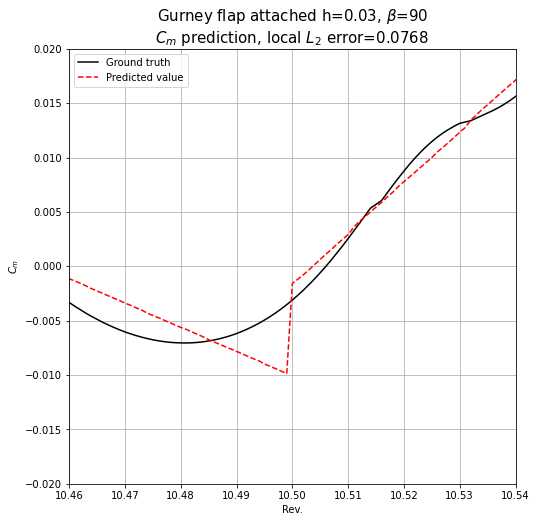

In [112]:
title_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, local $L_2$ error=%.4f'%(l2_error(predicted[449:500],y[449:500]))

plt.figure(figsize=(8,8))
plt.plot(t, cm, 'k-', label='Ground truth')
plt.plot(t, denormalize(predicted), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
plt.xlim([10.46, 10.54])
plt.ylim([-0.02, 0.02])
plt.grid()
plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [84]:
l2_error(cm[449:500], denormalize(predicted[449:500]))

0.45937481239588107

In [88]:
cm.shape

(1000, 1)

In [119]:
l2_error(np.concatenate((denormalize(predicted)[:449], denormalize(predicted)[500:]), axis=0), np.concatenate((cm[:449], cm[500:]), axis=0))

0.006956509465272106

In [107]:
np.sum((predicted[449:500]-y[449:500])**2)

0.0065009696071499055

In [103]:
np.sum((y[449:500])**2)

1.1017189825068427

In [104]:
np.sqrt(0.0065/1.1017)

0.07681128022209009

In [108]:
l2_error(predicted[449:500], y[449:500])

0.07681634721299024

In [ ]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

In [122]:
l2_error(np.concatenate((predicted[:449], predicted[500:])), np.concatenate((y[:449],y[500:])))

0.005039575137453226

In [116]:
np.sum((np.concatenate((y[:449],y[500:]))-np.concatenate((predicted[:449], predicted[500:]), axis=0))**2)

0.0054068123109621315

In [120]:
np.sum((np.concatenate((y[:449],y[500:]), axis=0))**2)

212.88910913145202

In [118]:
np.sqrt(0.0054/212.88)

0.00503650708404806